# **Phase 2 - Milestone 2**

**Ediashta Revindra Amirussalam**
<br>FTDS-020-RMT

## Objective

## 00 - Import Libraries

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import glob
import random
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [43]:
tf.__version__

'2.13.0'

In [44]:
tf.config.list_physical_devices('GPU')

[]

## 01 - Data Loading

In [45]:
main_path = ('./datasets/')
os.listdir(main_path)

['test', 'train']

In [46]:
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
os.listdir(train_dir)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [47]:
def check_dir(dir=None, labels=None):
  i=0
  for label in labels:
    num_data= len(os.listdir(os.path.join(dir, label)))
    print(f'Data', label, ' :', num_data)
    i+= num_data
  print('Total Data :', i)
    


In [48]:
print('train set: \n' + '='*50)
check_dir(train_dir,os.listdir(train_dir))
print('\ntest set: \n' + '='*50)
check_dir(test_dir,os.listdir(test_dir))

train set: 
Data angry  : 3995
Data disgusted  : 436
Data fearful  : 4097
Data happy  : 7215
Data neutral  : 4965
Data sad  : 4830
Data surprised  : 3171
Total Data : 28709

test set: 
Data angry  : 958
Data disgusted  : 111
Data fearful  : 1024
Data happy  : 1774
Data neutral  : 1233
Data sad  : 1247
Data surprised  : 831
Total Data : 7178


## 02 - EDA & Preprocessing

### Display Sample Image

(48, 48)


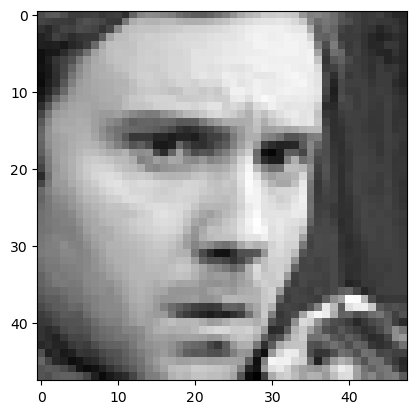

In [49]:
img = plt.imread('./datasets/train/angry/im0.png')
print(img.shape)
plt.imshow(img, cmap="gray")

#### Image Distribution

In [188]:
img_count = []

for i in os.listdir(train_dir):
    value = len([fn for fn in os.listdir(f'{train_dir}/{i}/') if fn.endswith('.png')])
    img_count.append(value)

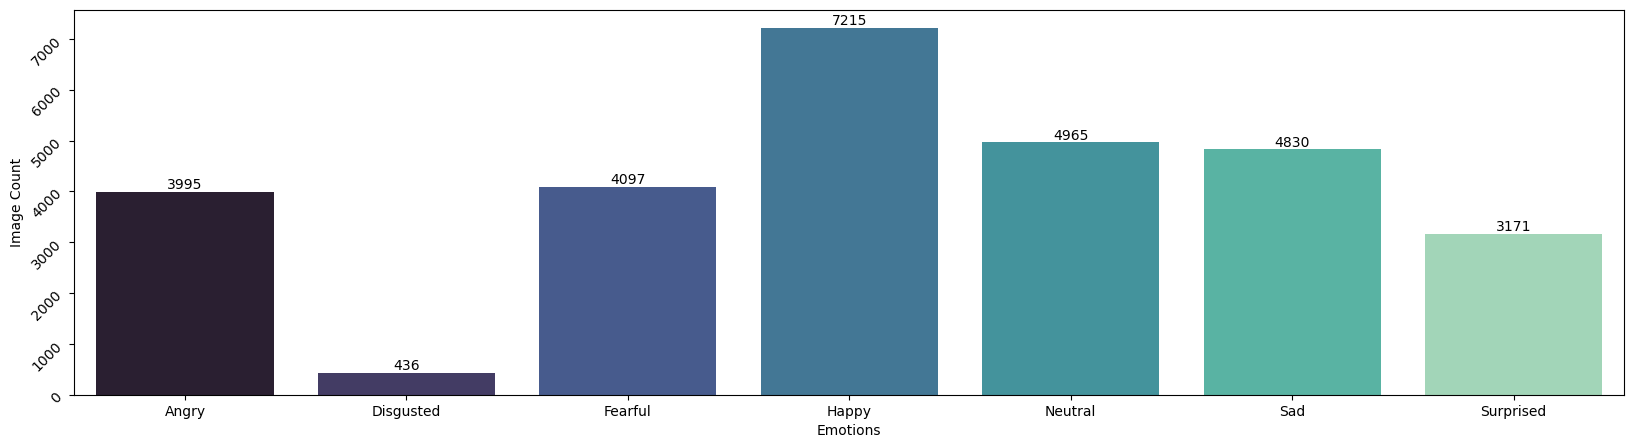

In [190]:
plt.figure(figsize=(20,5))
fig = sns.barplot(x=class_labels, 
                  y=img_count, 
                  palette="mako")
fig.set(xlabel="Emotions", ylabel="Image Count")

for i in fig.containers:
    fig.bar_label(i,)

plt.yticks(rotation=45)
plt.show()

### Individual Emotion Analysis

In [163]:
def visualize_img(title, train_dir):
    images = random.sample([fn for fn in os.listdir(f'{train_dir}/{title}') if fn.endswith('.png')],7)
    fig, axes = plt.subplots(1,7, figsize=(21,5))
    
    for i, x in enumerate(images):
        img = plt.imread(f'{train_dir}/{title}/{x}')
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(title.capitalize())
        axes[i].axis('off')
    
    fig.tight_layout()

#### Angry

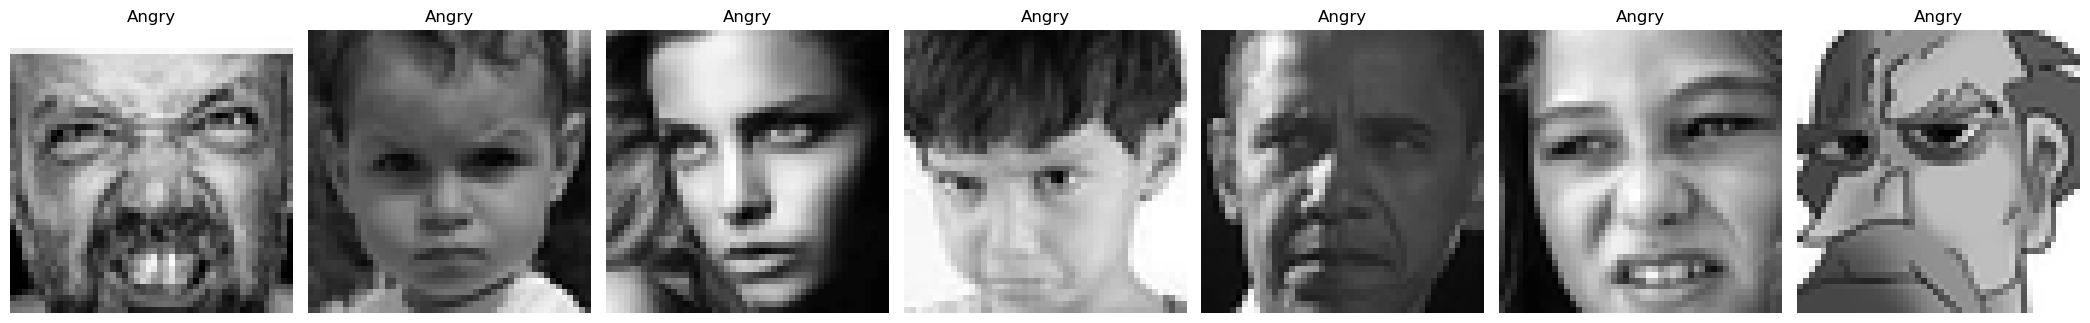

In [164]:
visualize_img('angry', train_dir)

#### Disgusted

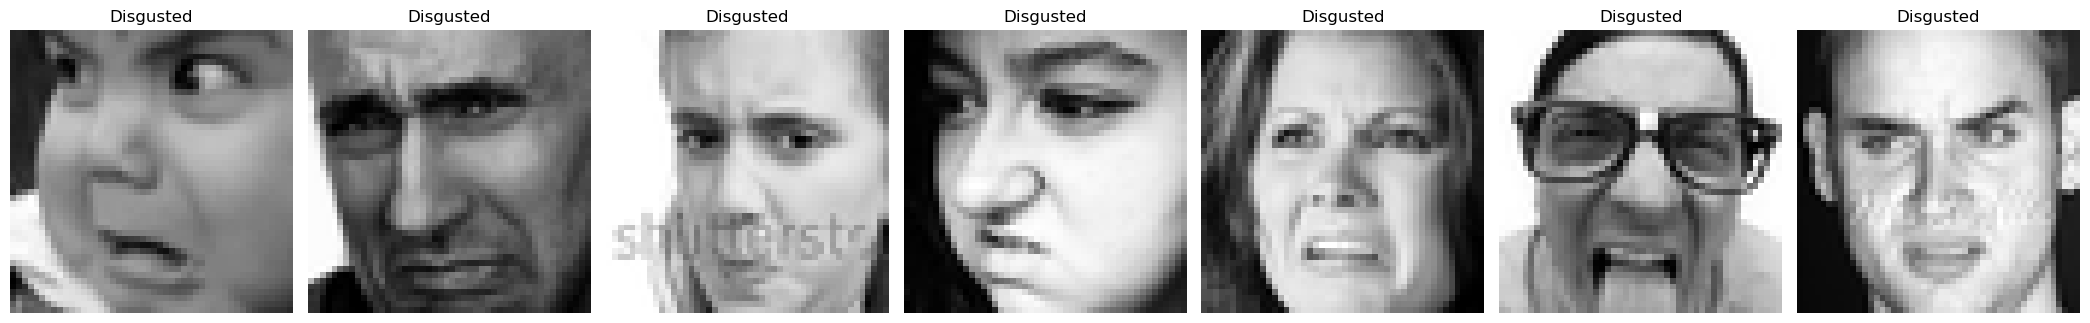

In [165]:
visualize_img('disgusted', train_dir)

#### Fearful

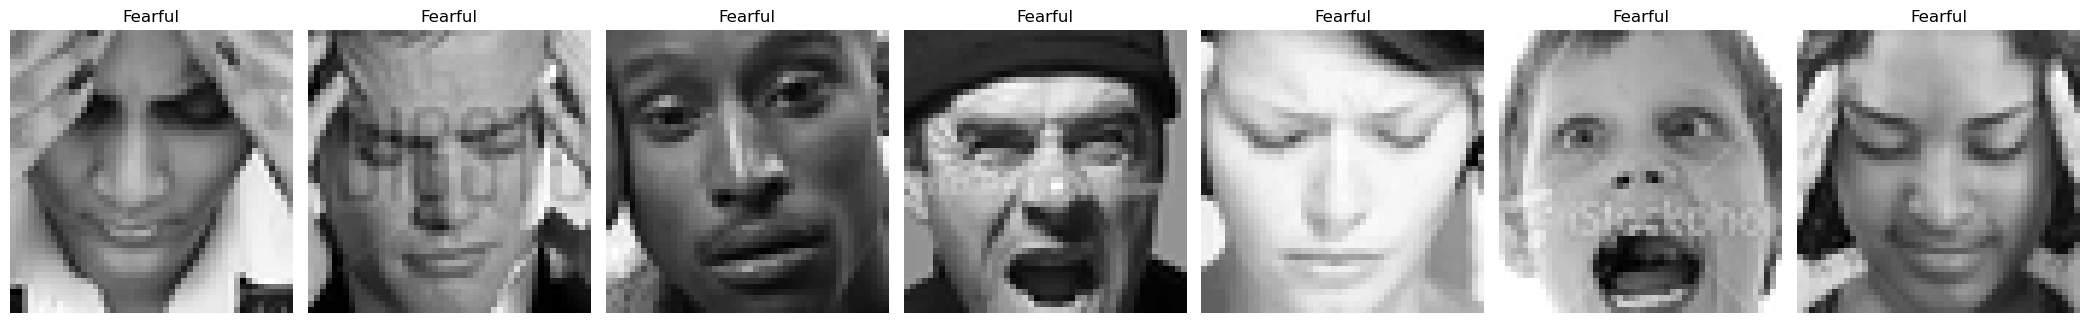

In [166]:
visualize_img('fearful', train_dir)

#### Happy

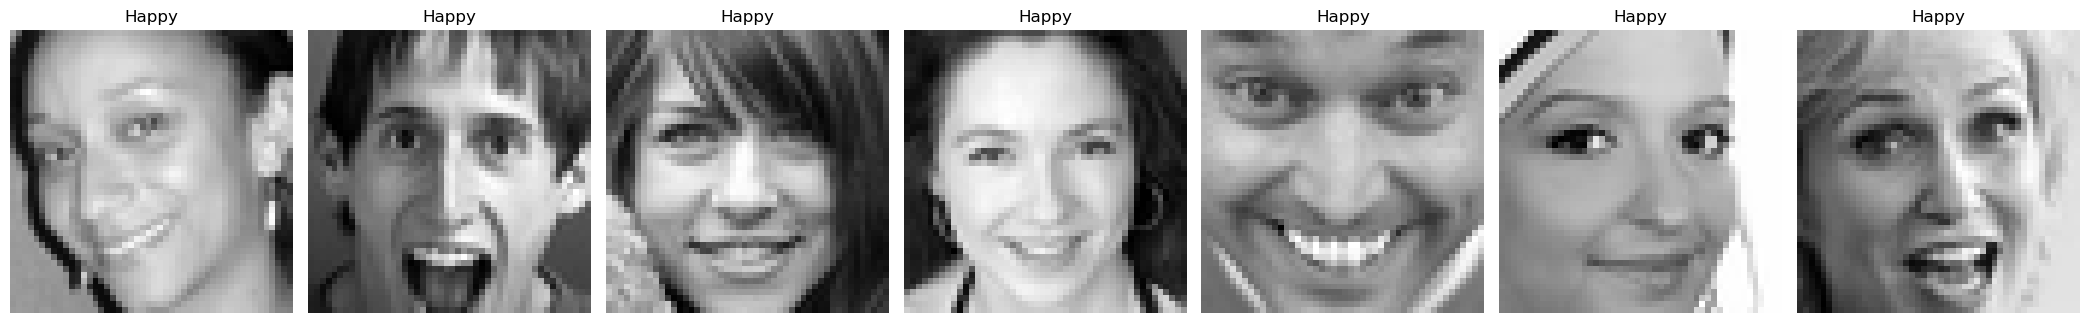

In [167]:
visualize_img('happy', train_dir)

#### Neutral

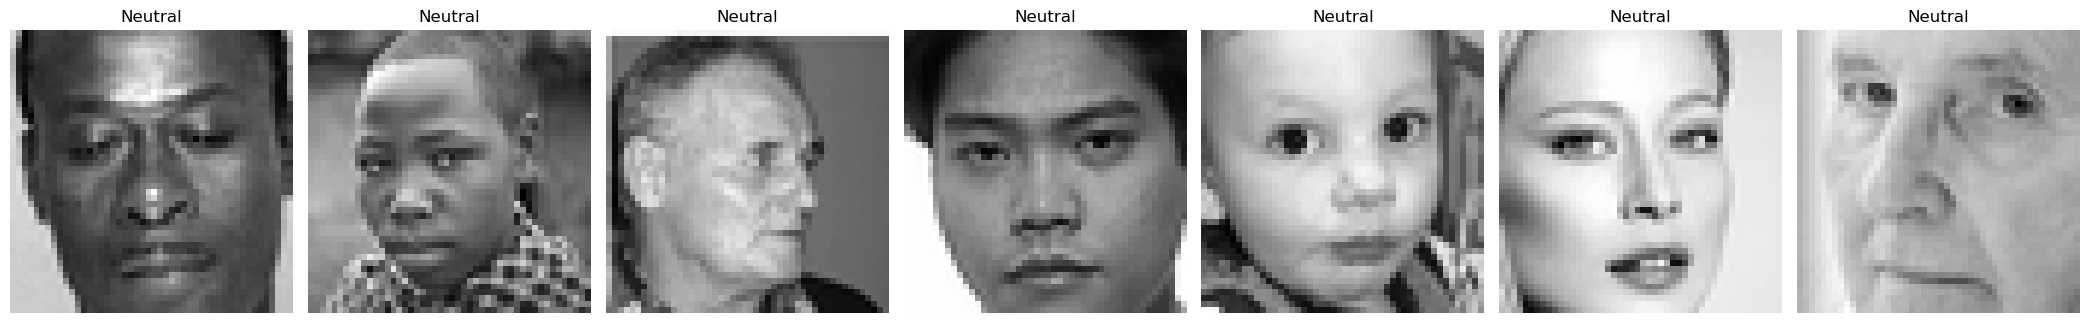

In [168]:
visualize_img('neutral', train_dir)

#### Sad

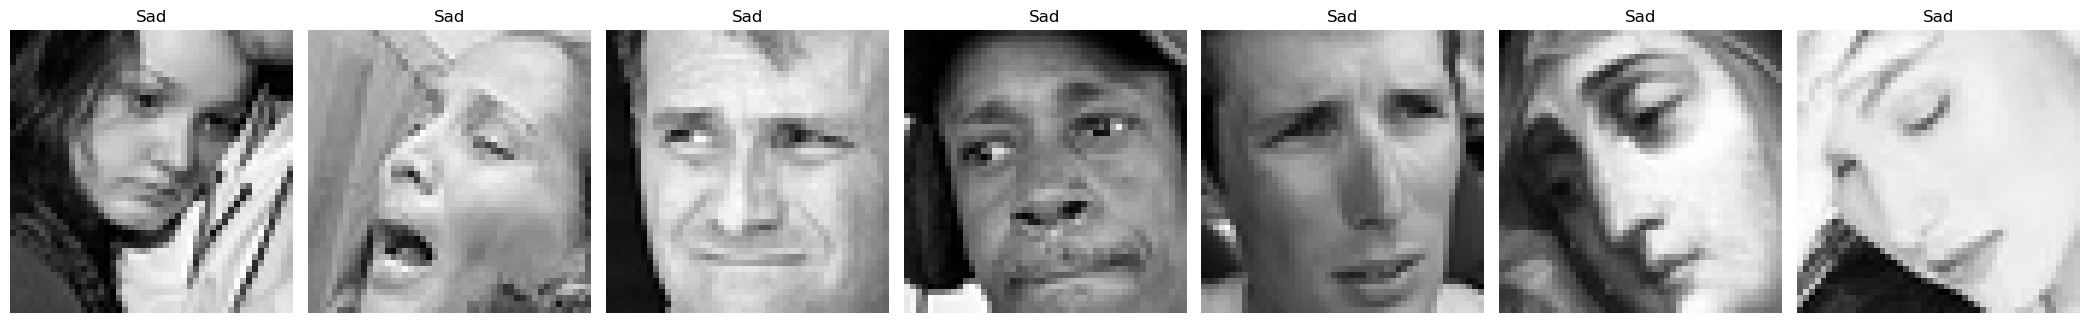

In [169]:
visualize_img('sad', train_dir)

#### Surprised

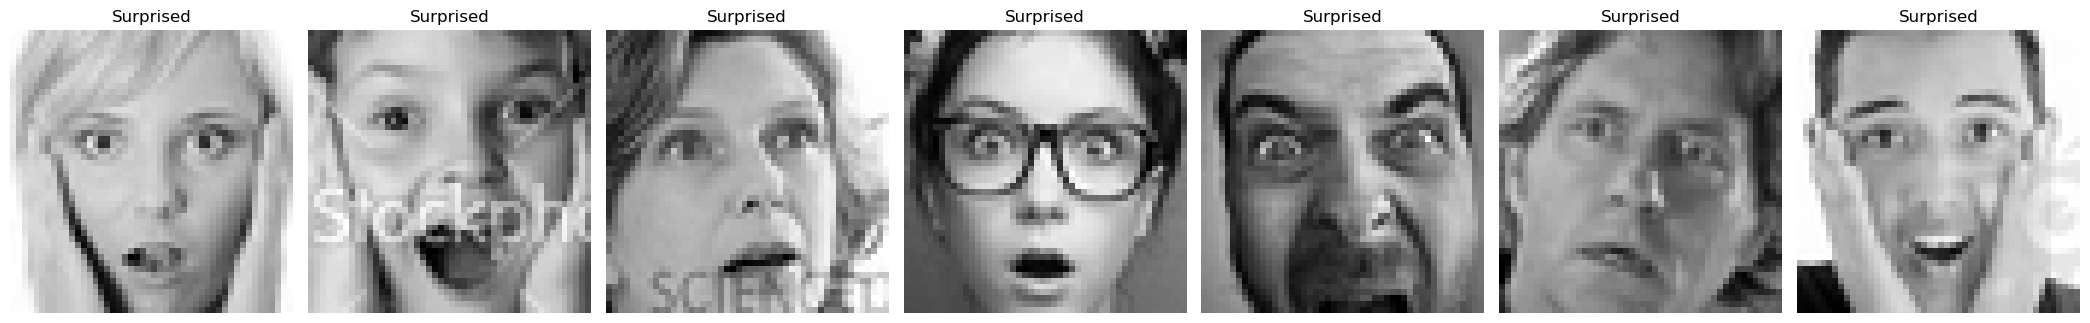

In [170]:
visualize_img('surprised', train_dir)

### Image Vector Mean

In [73]:
def img2np(path, list_of_filename, size = (48, 48)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

In [195]:
def find_mean_img(full_mat, title, axes, loc, size = (48, 48)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    
    # Create the sharpening kernel
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    
    # Apply the sharpening kernel to the image using filter2D
    sharpened = cv2.filter2D(mean_img, -1, kernel)
    
    mean_img = sharpened
        
    axes[loc].imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    axes[loc].set_title(f'Average {title}')
    return mean_img

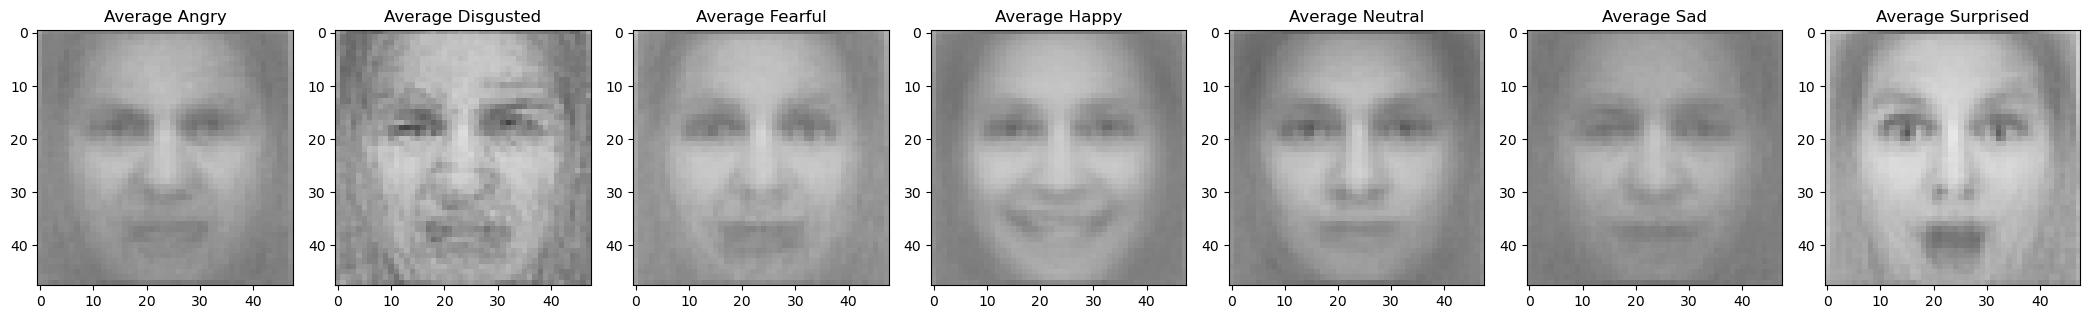

In [196]:
fig, axes= plt.subplots(1,7, figsize=(21,3))
count = 0

for i in os.listdir(train_dir):
    images = [fn for fn in os.listdir(f'{train_dir}/{i}') if fn.endswith('.png')]
    vector = img2np(f'{train_dir}/{i}/',images)
    find_mean_img(vector, i.capitalize(),axes, count)
    
    count+=1
    
plt.tight_layout()
plt.show()

### Preprocessing and Augmentation

In [175]:
class_labels  = [class_name.capitalize() for class_name in os.listdir(train_dir)]
img_height = 48
img_width = 48
batch_size = 64

In [173]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2,
                                  preprocessing_function=preprocess_fun)

train_ds = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

val_ds = test_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (img_height ,img_width),
                                                         batch_size = batch_size,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_ds = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (img_height ,img_width),
                                                    batch_size = batch_size,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [174]:
for image_batch , label_batch in train_ds:
  print(image_batch.shape)
  print(label_batch.shape)
  break

(64, 48, 48, 3)
(64, 7)


## 03 - Model - No Transfer Learning

In [208]:
# clear session

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [204]:
# Define the input shape and number of classes for your dataset
input_shape = (img_height, img_width, 3)
num_classes = 7

In [209]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [210]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

In [ ]:
history = model.fit(x = train_ds,
                    epochs = 30,
                    validation_data = val_ds)